In [99]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import calendar

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import Birch

import seaborn as sns

In [100]:
df_item = pd.read_csv("/content/olist_order_items_dataset.csv")
df_reviews = pd.read_csv("/content/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("/content/olist_orders_dataset.csv")
df_products = pd.read_csv("/content/olist_products_dataset.csv")
df_sellers = pd.read_csv("/content/olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("/content/olist_order_payments_dataset.csv")
df_customers = pd.read_csv("/content/olist_customers_dataset.csv")
df_category = pd.read_csv("/content/product_category_name_translation.csv")

## **Data cleaning**

**Checking for null values for all the dataframes.**

In [101]:
df_names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_sellers', 'df_order_pay', 'df_customers', 'df_category']

for names in df_names:
    print("In {} there are approximately {} null values".format(names, eval(names).isnull().sum().sum()))

In df_item there are approximately 0 null values
In df_reviews there are approximately 145903 null values
In df_orders there are approximately 4908 null values
In df_products there are approximately 2448 null values
In df_sellers there are approximately 0 null values
In df_order_pay there are approximately 0 null values
In df_customers there are approximately 0 null values
In df_category there are approximately 0 null values


For the above output following dataframes need to be cleaned.
1. Reviews
2. Orders
3. Products

### **Order Details Cleanup**

In [102]:
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [103]:
# Order approval is after the customer purchases the product. So missing order_approved_at can be substituted with order_purchase_timestamp
df_orders["order_approved_at"] = df_orders["order_approved_at"].fillna(df_orders["order_purchase_timestamp"])

In [104]:
# Order carrier is after the order approval ie., order might be shipped on the day of confirmation. So missing order_delivered_carrier_date can be substituted with order_approved_at
df_orders["order_delivered_carrier_date"] = df_orders["order_delivered_carrier_date"].fillna(df_orders["order_approved_at"])

In [105]:
# Estimated delivery date is often later than actual delivery date. so missing delivery date is substituted with estimated delivery date.
df_orders["order_delivered_customer_date"] = df_orders["order_delivered_customer_date"].fillna(df_orders["order_estimated_delivery_date"])

In [106]:
df_orders.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

### **Product details cleanup**

In [107]:
df_products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [108]:
# Product dimension or name length doesn't provide much insight so eliminating them.
df_products = df_products[~(df_products['product_name_lenght'].isnull())]
df_products = df_products[~(df_products['product_weight_g'].isnull())]

In [109]:
df_products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

### **Review Details cleanup**

In [110]:
df_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [111]:
# Review title is missing throughout so drop the review_comment_title column
df_reviews = df_reviews.drop(['review_comment_title'], axis = 1)

In [112]:
# Review comments are important going further so i'll update the null values with None
df_reviews['review_comment_message'] = df_reviews['review_comment_message'].fillna('none')

In [113]:
df_reviews.isnull().sum()

review_id                  0
order_id                   0
review_score               0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

## **Data Preparation**

In [114]:
# Merging all csv into one
df = df_customers.merge(df_orders, on = 'customer_id', how = 'left')
df = df.merge(df_item, on = 'order_id', how = 'outer')
df = df.merge(df_order_pay, on = 'order_id', how = 'outer', validate='m:m')
df = df.merge(df_reviews, on = 'order_id', how = 'outer')
df = df.merge(df_products, on = 'product_id', how = 'outer')
df = df.merge(df_category, on = 'product_category_name', how = 'outer', validate='m:m')
df = df.merge(df_sellers, on = 'seller_id', how = 'outer')

## **Data Analysis**

In [115]:
# Converting the delivery and purchase timestamp to date and time format using pandas
df[['order_purchase_timestamp', 'order_delivered_customer_date']]=df[['order_purchase_timestamp', 'order_delivered_customer_date']].apply(pd.to_datetime)

df['Year'] = df['order_purchase_timestamp'].dt.year

year_value = df.groupby('Year').size()
year_name = year_value.index

fig = px.pie(df["Year"], values=year_value, names=year_name, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Pie chart shows the the increase in sales every year from 2016 to 2018.

---



Understand which month and day has more sales, which helps retailers to offer promotions.

In [116]:
df['Month'] =  pd.Series(pd.Categorical(df['order_purchase_timestamp'].dt.month_name(), categories=list(calendar.month_name)[1:]))

month_values = df.groupby('Month').size()
month_names = list(calendar.month_name)[1:]

fig = px.bar(df, x=month_values, y=month_names, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

From the above graph we can depict that the August is month which has more sales in Brazil.



In [117]:
df['Day'] =  pd.Series(pd.Categorical(df['order_purchase_timestamp'].dt.day_name(), categories=list(calendar.day_name)))

day_values = df.groupby('Day').size()
day_names = list(calendar.day_name)

fig = px.bar(df, x=day_values, y=day_names, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Monday is where most of the orders are placed by the customers.


---



Understanding Product sales

In [118]:
import plotly.express as px

product_name = df["product_category_name_english"].value_counts().sort_values(ascending=False)[:10]

fig = px.bar(df, x=product_name.values, y=product_name.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Bed_bath_table followed by health_beauty has the highest sales across Brazil.

---



Understanding the payment mode

In [119]:
df["payment_type"].replace({"not_defined": "credit_card"}, inplace=True)
df['payment_type'] = df['payment_type'].fillna("credit_card")

In [120]:
paymt_type = df.payment_type.unique()
values = df["payment_type"].value_counts()

fig = px.pie(df["payment_type"], values=values, names=paymt_type, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Almost 3/4th of the customers use credit card to buy the products, offering discount on credit card will increase sales.

---



Understanding which state has more customers

In [121]:
state = df.customer_state.unique()
customer_count = df["customer_state"].value_counts()

fig = px.bar(df, x=customer_count, y=state, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Sao Paulo state has highest customer for this retail store.

## **Feature Extraction**

**Monetary**

Customer who has contributed more revenue

In [122]:
df['total_payment'] = df['payment_value'] * df['payment_installments']

In [123]:
#get the payment amount per customer
df_monetary = df.groupby('customer_unique_id')['total_payment'].sum()
df_monetary = df_monetary.reset_index()

# generate revenue column ie., monetary for each customer
df_monetary.columns = ['customer_unique_id', 'monetary']

fig = px.histogram(df_monetary, x = 'monetary', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [124]:
print(df_monetary['monetary'].describe())

count     96096.000000
mean        882.248653
std        3394.450208
min           0.000000
25%          82.730000
50%         206.995000
75%         642.330000
max      345624.000000
Name: monetary, dtype: float64


**Frequency**

Total number of orders for each customer

In [125]:
#get the number of orders per customer
df_frequency = df.groupby('customer_unique_id')['order_id'].count()
df_frequency = df_frequency.reset_index()

#generate frequency column for each customer
df_frequency.columns = ['customer_unique_id', 'frequency']

fig = px.histogram(df_frequency, x = 'frequency', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [126]:
print(df_frequency['frequency'].describe())

count    96096.000000
mean         1.239833
std          0.853158
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         75.000000
Name: frequency, dtype: float64


**Recency**

Most recent date of purchase and inactive period 

In [127]:
#get the max purchase date for each customer and create a dataframe with it
df_recency = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
df_recency['Recency'] = (df_recency['MaxPurchaseDate'].max() - df_recency['MaxPurchaseDate']).dt.days

fig = px.histogram(df_recency, x = 'Recency', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [128]:
print(df_recency['Recency'].describe())

count    96096.000000
mean       287.735691
std        153.414676
min          0.000000
25%        163.000000
50%        268.000000
75%        397.000000
max        772.000000
Name: Recency, dtype: float64


In [129]:
mfr_df = pd.merge(df_monetary, df_frequency, on='customer_unique_id', how='inner')
mfr_df = pd.merge(mfr_df, df_recency, on='customer_unique_id', how='inner')

mfr_df = mfr_df.drop('MaxPurchaseDate', axis = 1)

## **K-Measns clustering customers based on Monetary, Frequency and Recency**

**Finding optimal number of cluster using Elbow method**

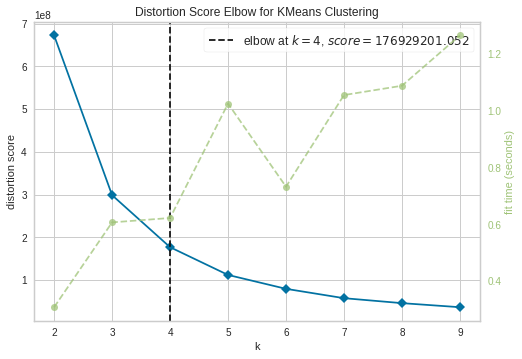

In [130]:
from yellowbrick.cluster import KElbowVisualizer

recency = mfr_df[['Recency']]

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(recency)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**Silhouette** **analysis**

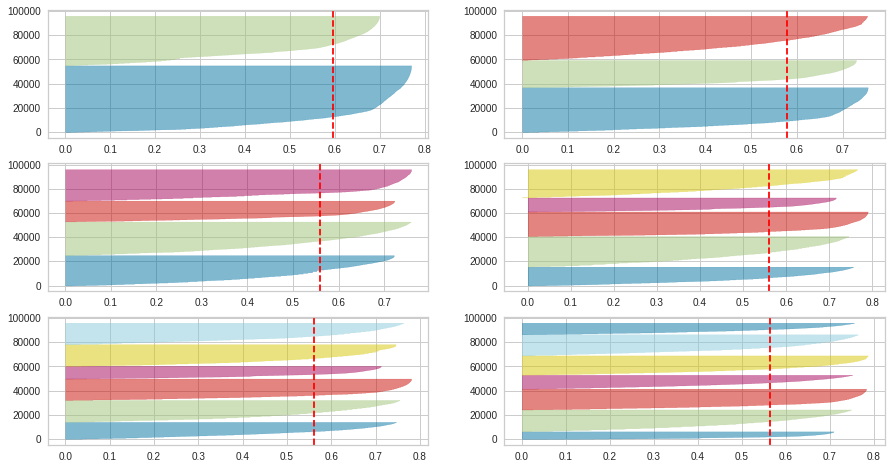

In [131]:
from yellowbrick.cluster import SilhouetteVisualizer

recency = mfr_df[['Recency']]

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(recency) 

Silhouette score and Elbow method provides k = 4 is better. Going with K = 4 for better number of clusters

In [132]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [133]:
# Kmeans cluster for monetary
kmeans = KMeans(n_clusters=4)
kmeans.fit(mfr_df[['Recency']])
mfr_df['RecencyCluster'] = kmeans.predict(mfr_df[['Recency']])

mfr_df = order_cluster('RecencyCluster', 'Recency',mfr_df,False)

mfr_df.groupby('RecencyCluster')['Recency'].describe()

count        mean        std  ...    50%    75%    max
RecencyCluster                                  ...                     
0               17020.0  534.805523  59.273438  ...  526.0  576.0  772.0
1               25275.0  363.972463  43.905829  ...  357.0  401.0  449.0
2               27862.0  232.591810  35.267120  ...  232.0  264.0  298.0
3               25939.0  110.566406  36.071041  ...  110.0  144.0  171.0

[4 rows x 8 columns]

In [134]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(mfr_df[['frequency']])
mfr_df['FrequencyCluster'] = kmeans.predict(mfr_df[['frequency']])

#order the frequency cluster
mfr_df = order_cluster('FrequencyCluster', 'frequency',mfr_df,True)

#see details of each cluster
mfr_df.groupby('FrequencyCluster')['frequency'].describe()

count       mean        std   min   25%   50%   75%   max
FrequencyCluster                                                             
0                 81601.0   1.000000   0.000000   1.0   1.0   1.0   1.0   1.0
1                 12605.0   2.162713   0.369118   2.0   2.0   2.0   2.0   3.0
2                  1846.0   5.086674   1.655431   4.0   4.0   4.0   6.0  12.0
3                    44.0  20.250000  10.257442  13.0  14.0  18.0  24.0  75.0

In [135]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(mfr_df[['monetary']])
mfr_df['MonetaryCluster'] = kmeans.predict(mfr_df[['monetary']])

#order the monetary cluster
mfr_df = order_cluster('MonetaryCluster', 'monetary',mfr_df,True)

#see details of each cluster
mfr_df.groupby('MonetaryCluster')['monetary'].describe()

count           mean  ...        75%        max
MonetaryCluster                          ...                      
0                92897.0     510.806610  ...     553.77    4844.48
1                 3001.0    9194.885691  ...   10799.80   25411.68
2                  189.0   41950.892804  ...   45462.40  117450.00
3                    9.0  200621.578889  ...  223466.00  345624.00

[4 rows x 8 columns]

In [136]:
#calculate overall score and use mean() to see details
mfr_df['OverallScore'] = mfr_df['RecencyCluster'] + mfr_df['FrequencyCluster'] + mfr_df['MonetaryCluster']
mfr_df.groupby('OverallScore')['Recency','frequency','monetary'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Recency  frequency       monetary
OverallScore                                      
0             534.561543   1.000000     476.913023
1             380.871449   1.097038     604.825227
2             254.870064   1.177804     690.792903
3             135.874447   1.237983     775.845168
4             138.270602   2.413889    2772.982144
5             146.158170   4.219608    8349.952196
6             137.438272   6.123457   23358.583704
7             142.657895   8.157895   51913.850789
8             146.666667   8.333333  185762.246667
9              70.000000  24.000000  167612.760000

The scoring above clearly shows us that customers with score 9 is our best customers whereas 0 is the worst.

we name these scores:


0 to 2: Low Value


3 to 5: Mid Value


6+: High Value

In [137]:
mfr_df['Segment'] = 'Low-Value'
mfr_df.loc[mfr_df['OverallScore']>2,'Segment'] = 'Mid-Value' 
mfr_df.loc[mfr_df['OverallScore']>5,'Segment'] = 'High-Value' 

### **Customer Segmentation**

In [138]:
def segmentation_graph(data):
  plt.figure(figsize=(10,5))
  percentage = (data.value_counts(normalize=True)* 100).reset_index(name='percentage')
  g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="gist_earth")
  sns.despine(bottom = True, left = True)
  for i, v in enumerate(percentage['percentage']):
      g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
  g.set_ylabel('Segmentation')
  g.set(xticks=[])
  plt.show()

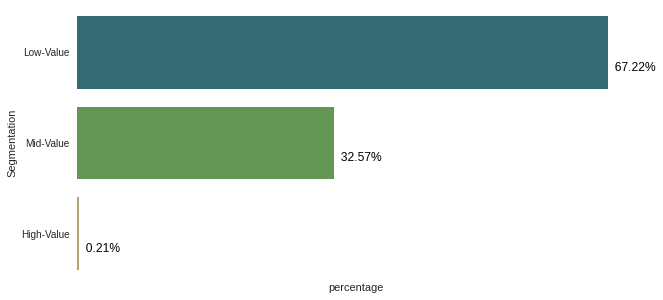

In [139]:
segmentation_graph(mfr_df['Segment'])

### **Visualization of clusters**

In [140]:
!pip install chart_studio

In [141]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

def plot_sengmentation_graphs(query_low_value, query_mid_value, query_high_value, x_value, y_value):
  #Monetary vs Frequency
  mf_graph = mfr_df.query("monetary < 60000 and frequency < 10000")

  plot_data = [
      go.Scatter(
          x=mf_graph.query(query_low_value)[x_value],
          y=mf_graph.query(query_low_value)[y_value],
          mode='markers',
          name='Low',
          marker= dict(size= 7,
              line= dict(width=1),
              color= 'blue',
              opacity= 0.8
            )
      ),
          go.Scatter(
          x=mf_graph.query(query_mid_value)[x_value],
          y=mf_graph.query(query_mid_value)[y_value],
          mode='markers',
          name='Mid',
          marker= dict(size= 9,
              line= dict(width=1),
              color= 'green',
              opacity= 0.5
            )
      ),
          go.Scatter(
          x=mf_graph.query(query_high_value)[x_value],
          y=mf_graph.query(query_high_value)[y_value],
          mode='markers',
          name='High',
          marker= dict(size= 11,
              line= dict(width=1),
              color= 'red',
              opacity= 0.9
            )
      ),
  ]

  plot_layout = go.Layout(
          yaxis= {'title': y_value},
          xaxis= {'title': x_value},
          title='Segments'
      )
  fig = go.Figure(data=plot_data, layout=plot_layout)
  pyoff.iplot(fig)


In [142]:
plot_sengmentation_graphs("Segment == 'Low-Value'", "Segment == 'Mid-Value'", "Segment == 'High-Value'", "frequency", "monetary")

In [143]:
plot_sengmentation_graphs("Segment == 'Low-Value'", "Segment == 'Mid-Value'", "Segment == 'High-Value'", "Recency", "monetary")

In [144]:
plot_sengmentation_graphs("Segment == 'Low-Value'", "Segment == 'Mid-Value'", "Segment == 'High-Value'", "Recency", "frequency")

## **BIRCH clustering method**

In [145]:
# Birch cluster for recency
brc = Birch(n_clusters=4)
brc.fit(mfr_df[['Recency']])
mfr_df['RecencyCluster_brc'] = brc.predict(mfr_df[['Recency']])

mfr_df = order_cluster('RecencyCluster_brc', 'Recency',mfr_df,False)

mfr_df.groupby('RecencyCluster_brc')['Recency'].describe()

count        mean        std  ...    50%    75%    max
RecencyCluster_brc                                  ...                     
0                   10510.0  570.033777  47.507990  ...  565.0  598.0  772.0
1                   21473.0  419.329763  47.741246  ...  417.0  459.0  508.0
2                   27966.0  279.141279  36.938685  ...  277.0  316.0  340.0
3                   36147.0  134.131768  48.931811  ...  134.0  176.0  216.0

[4 rows x 8 columns]

In [146]:
# Birch cluster for frequency
brc = Birch(n_clusters=4)
brc.fit(mfr_df[['frequency']])
mfr_df['FrequencyCluster_brc'] = brc.predict(mfr_df[['frequency']])

#order the frequency cluster
mfr_df = order_cluster('FrequencyCluster_brc', 'frequency',mfr_df,True)

#see details of each cluster
mfr_df.groupby('FrequencyCluster_brc')['frequency'].describe()

count       mean       std  ...   50%    75%   max
FrequencyCluster_brc                                ...                   
0                     96071.0   1.233661  0.740273  ...   1.0   1.00  15.0
1                        22.0  21.636364  3.170481  ...  21.0  24.00  29.0
2                         2.0  36.500000  2.121320  ...  36.5  37.25  38.0
3                         1.0  75.000000       NaN  ...  75.0  75.00  75.0

[4 rows x 8 columns]

In [147]:
# Birch cluster for monetary
brc = Birch(n_clusters=4)
brc.fit(mfr_df[['monetary']])
mfr_df['MonetaryCluster_brc'] = brc.predict(mfr_df[['monetary']])

#order the frequency cluster
mfr_df = order_cluster('MonetaryCluster_brc', 'monetary',mfr_df,True)

#see details of each cluster
mfr_df.groupby('MonetaryCluster_brc')['monetary'].describe()

count           mean  ...          75%       max
MonetaryCluster_brc                          ...                       
0                    94876.0     638.199155  ...     601.0275    9428.4
1                      974.0   13716.557464  ...   16286.0000   22256.9
2                      238.0   38614.164412  ...   42741.7000  124908.8
3                        8.0  210085.676250  ...  227051.3850  345624.0

[4 rows x 8 columns]

In [148]:
#calculate overall score and use mean() to see details
mfr_df['OverallScore_brc'] = mfr_df['RecencyCluster_brc'] + mfr_df['FrequencyCluster_brc'] + mfr_df['MonetaryCluster_brc']
mfr_df.groupby('OverallScore_brc')['Recency','frequency','monetary'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Recency  frequency       monetary
OverallScore_brc                                      
0                 569.950463   1.218134     681.395731
1                 420.369496   1.231762     738.788350
2                 280.549608   1.225572     757.164314
3                 135.474931   1.231390     775.794314
4                 160.288636   2.838636   17020.348159
5                 139.825243   4.436893   43899.581165
6                 212.000000  12.000000  190739.662500
7                  70.000000  24.000000  167612.760000

### **Customer Segmentation**

In [149]:
mfr_df['Segment_brc'] = 'Low-Value'
mfr_df.loc[mfr_df['OverallScore_brc']>2,'Segment_brc'] = 'Mid-Value' 
mfr_df.loc[mfr_df['OverallScore_brc']>5,'Segment_brc'] = 'High-Value' 

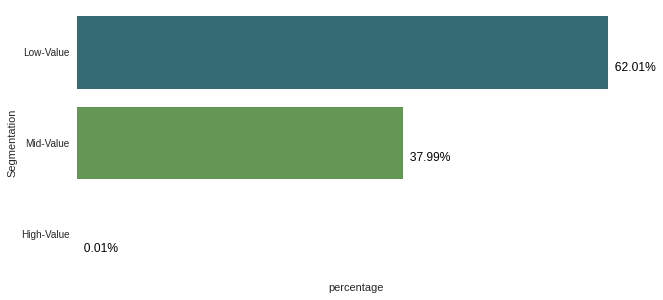

In [150]:
segmentation_graph(mfr_df['Segment_brc'])

### **Visualization of clusters**

In [151]:
plot_sengmentation_graphs("Segment_brc == 'Low-Value'", "Segment == 'Mid-Value'", "Segment == 'High-Value'", "frequency", "monetary")

In [152]:
plot_sengmentation_graphs("Segment_brc == 'Low-Value'", "Segment == 'Mid-Value'", "Segment == 'High-Value'", "Recency", "monetary")

In [153]:
plot_sengmentation_graphs("Segment_brc == 'Low-Value'", "Segment == 'Mid-Value'", "Segment == 'High-Value'", "Recency", "frequency")

## **Summary of clustering**

With the visualization of segmentation it is quite evident that following actions need to be performed:

For **High Value** customers, we should take actions such as offers, discount to increase retention

For **Mid Value** customers, we should take actions such as offers, discount to increase retention by which there frequency also increases.

For **Low Value** customers, we should take action such that it increases frequency.